<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/39_4_Bert%3D%3D4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from transformers import pipeline
# model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
# model("Я тебя не")

In [1]:
%%capture
!pip install emoji==1.4.1
!pip install imblearn

In [7]:
import numpy as np
import pandas as pd
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
seed=42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.style.use("Solarize_Light2")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [8]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['perfumes', 'smartphones', 'car-electronics', 'memory-cards',
              'wearables', 'tires', 'power-banks', 'portable-speakers', 'car-audio',
              'books', 'beauty', 'small-home-appl', 'kitchen-home-appl']

    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

In [11]:
# Загружаем датасет
df = pd.read_csv("/content/kaspi_reviews.csv", encoding='utf-8')
df.columns

Index(['Unnamed: 0', 'text', 'plus', 'minus', 'language', 'rating',
       'category'],
      dtype='object')

In [12]:
df

,Unnamed: 0,text,plus,minus,language,rating,category
0,0,"Парфюм оригинальный. Всё, как в профессиональн...",NaN,NaN,russian,5.0,perfumes
1,1,Мой любимый DKNY. Запах просто шикарный. Спаси...,NaN,NaN,russian,5.0,perfumes
2,2,NaN,Шикарный запах! Безумно нравится! Не пожалеете...,NaN,russian,5.0,perfumes
3,3,NaN,Иісі қатты ұнады.,NaN,kazakh,5.0,perfumes
4,4,"Запах просто классный, как раз то, что мне нуж...","Мне все понравилось - и качество товара, и зап...","Единственное, что мне не понравилось, это то, ...",russian,4.0,perfumes
...,...,...,...,...,...,...,...
119043,119043,NaN,"Звук выше среднего, немного токсичные высокие ...","Нет aptx, немного тяжеловаты.",russian,5.0,headphones
119044,119044,"Вполне сносные наушники, но, думаю, не стоит с...",NaN,NaN,russian,4.0,headphones
119045,119045,Наушники просто супер,NaN,NaN,russian,5.0,headphones
119046,119046,NaN,Всё супер,Басов маловато,russian,4.0,headphones


In [13]:
# Удаляем строки с казахским языком
df = df.drop(df[df['language'] == "kazakh"].index)

In [14]:
# Удаляем лишние столбцы
df = df.drop(['Unnamed: 0', 'plus', 'minus', 'language', 'rating'], axis=1)

In [15]:
# Удаляем все строки с пропущенными значениями
df = df.dropna()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55938 entries, 0 to 119045
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      55938 non-null  object
 1   category  55938 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [17]:
df['category'].unique()

array(['perfumes', 'smartphones', 'car-electronics', 'memory-cards',
       'wearables', 'tires', 'power-banks', 'portable-speakers',
       'car-audio', 'books', 'beauty', 'small-home-appl',
       'kitchen-home-appl', 'big-home-appl', 'climate-equipment',
       'watches', 'headphones'], dtype=object)

In [18]:
df['category'].value_counts()

,count
category,
smartphones,21497
kitchen-home-appl,5961
small-home-appl,5803
big-home-appl,5556
headphones,3076
beauty,3076
climate-equipment,2451
tires,1890
car-electronics,1833


In [19]:
df

,text,category
0,"Парфюм оригинальный. Всё, как в профессиональн...",perfumes
1,Мой любимый DKNY. Запах просто шикарный. Спаси...,perfumes
4,"Запах просто классный, как раз то, что мне нуж...",perfumes
5,"Парфюм хороший, оригинал! Магазин Parfum-Shop-...",perfumes
6,Доставка работает супер!,perfumes
...,...,...
119039,С большим телефоном без наушников себя не пред...,headphones
119040,"Купил наушники 3 недели назад, сначала очень п...",headphones
119042,Хорошие наушники,headphones
119044,"Вполне сносные наушники, но, думаю, не стоит с...",headphones


In [20]:
df_train = df[:50000]
df_test = df[50001:]

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 106766
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      50000 non-null  object
 1   category  50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5937 entries, 106768 to 119045
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5937 non-null   object
 1   category  5937 non-null   object
dtypes: object(2)
memory usage: 139.1+ KB


In [ ]:
# def strip_emoji(text):
#     return re.sub(emoji.get_emoji_regexp(), r"", text) #удаляем emoji (смайлики)

# # Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
# def strip_all_entities(text):
#     text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # удаляем \n и \r и переводим строку в нижний регистр
#     text = re.sub(r"(?:\@|https?\://)\S+", "", text) # удаление ссылок и упоминаний других участников
#     text = re.sub(r'[^\x00-\x7f]',r'', text) # удаление символов не utf8/ascii, таких как '\x9a\x91\x97\x9a\x97'
#     banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§' # символы для удаления, включая пунктуацию
#     table = str.maketrans('', '', banned_list) # создание словаря замены
#     text = text.translate(table) # применение к строке словаря замены
#     return text

# # убираем хэштеги в конце предложения и оставляем в середине, удалив только символ #
# def clean_hashtags(tweet):
#     new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # удаление последнего хэштега
#     new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) # удаление символа хэштега в середине предложения
#     return new_tweet2

# # Фильтрация специальных символов, таких как & и $, присутствующих в некоторых словах
# def filter_chars(a):
#     sent = []
#     for word in a.split(' '):
#         if ('$' in word) | ('&' in word):
#             sent.append('')
#         else:
#             sent.append(word)
#     return ' '.join(sent)

# def remove_mult_spaces(text): # удаление множественных пробелов с помощью регулярки
#     return re.sub("\s\s+" , " ", text)

In [23]:
texts_new = []
for t in df_train.text:
    texts_new.append(t)

In [24]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(t)

In [ ]:
# texts_new = []
# for t in df_train.text:
#     texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
# texts_new_test = []
# for t in df_test.text:
#     texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [25]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [26]:
df_train['text_clean'].head(3)

,text_clean
0,"Парфюм оригинальный. Всё, как в профессиональн..."
1,Мой любимый DKNY. Запах просто шикарный. Спаси...
4,"Запах просто классный, как раз то, что мне нуж..."


In [27]:
df_test['text_clean'].head(3)

,text_clean
106768,"Я довольна покупкой, спасибо Каспи Магазину"
106769,Очень хороший обогреватель. Купили уже второй ...
106772,"Приобретайте те, у кого квадратура маленькая."


In [28]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df_train['text_len'] = text_len

In [29]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

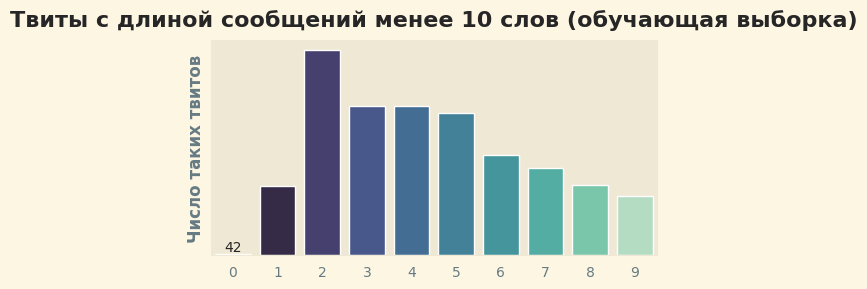

In [30]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

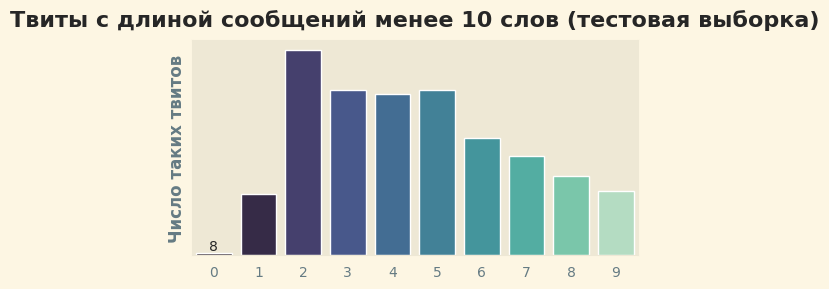

In [31]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (тестовая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

In [32]:
print(f"Форма обучающей выборки: {df_train.shape}")
print(f"Форма тестовой выборки: {df_test.shape}")

Форма обучающей выборки: (50000, 4)
Форма тестовой выборки: (5937, 4)


In [33]:
df_train = df_train[df_train['text_len'] > 0]
df_test = df_test[df_test['text_len'] > 0]

In [34]:
print(f"Форма обучающей выборки после очистки: {df_train.shape}")
print(f"Форма тестовой выборки после очистки: {df_test.shape}")

Форма обучающей выборки после очистки: (49958, 4)
Форма тестовой выборки после очистки: (5929, 4)


In [35]:
tokenizer = BertTokenizerFast.from_pretrained('seara/rubert-tiny2-russian-sentiment')

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [39]:
token_lens = []

for txt in df_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 512


In [40]:
token_lens = []

for i,txt in enumerate(df_train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 2, TEXT: Запах просто классный, как раз то, что мне нужно в летнее время. Принимаю душ и брызгаюсь, а дальше парфюм делает своё дело - он проявляет не запах какого-то парфюма, а мой, именно запах моего тела после душа, такой чистый запах, а после, когда уже температура тела горячая, аромат будто уже проявляет себя, запах каких-то нежных цветов, и то едва уловим, появляется и снова исчезает, будто порхает, не похож не на какие другие. Я рада, что приобрела данный аромат, мне как раз нравится, когда я не слышу свой парфюм у других рядом находящихся людей
INDEX: 160, TEXT: Прохлада - это время для смены ароматов, и рука сама тянется к моему самому любимому аромату на все времена. Нежный и яркий, кисло-сладкий, и не резкий. Всё в нём слишком идеально смешано, и база удивительная. Я обожаю свежесть без зелени и сладость без сахара. Любовь пахнет ванилью и цветами с маленькой каплей мужского аромата. В прохладную погоду аромат раскрывается по-особенному, он чудесен, нежный и свежий. М

In [41]:
df_train['token_lens'] = token_lens

In [42]:
df_train = df_train.sort_values(by='token_lens', ascending=False)
df_train.head(3)

,text,category,text_clean,text_len,token_lens
99356,Общее впечатление - машинка восхитительна! <br...,big-home-appl,Общее впечатление - машинка восхитительна! <br...,312,512
20911,"Много написано уже, буду краток!<br>Смарт купл...",smartphones,"Много написано уже, буду краток!<br>Смарт купл...",288,512
80906,"Будь проклят тот день, когда я села за баранку...",small-home-appl,"Будь проклят тот день, когда я села за баранку...",331,512


In [43]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [44]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)
print(f"Максимальная длина токенизированной последовательности: {max_len}")

Максимальная длина токенизированной последовательности: 512


In [45]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 81, TEXT: Во-первых, спасибо всем. Первый раз сделал покупку через Каспи Магазин. Понравилось. Удобно. Быстро. Оперативно. Покупаю во второй раз эту модель. Конечно, первая проработала где-то 7-8 месяцев. Может бракованная попалась, не знаю. Первые 2-3 месяца все было нормально, потом снизу, где кнопки, начала капать маленькими каплями. Видел, но внимания не обращал. Думал перестанет. И вот в конце января вообще замкнула и сгорела. Почему купил такой же? Да потому что под эту модель все было подведено, настроено, все трубы и вентили. Просто ту снял и на то место поставил новую. Поленился переделывать. Конечно, если и этот сгорит так скоро, то уже куплю другую модель. Но, надеюсь, что этот прослужит долго. Спасибо за внимание.
INDEX: 97, TEXT: Если бы не через Каспи Магазин покупали, обошлось бы намного дороже. Вообще всегда ищу возможность приобретать через Каспи Магазин. И описание товара и цена – всё можно выбрать, а оплата очень удобная. Можно оплатить не выходя из дома. Я по

In [46]:
df_test['token_lens'] = token_lens_test

In [47]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(3)

,text,category,text_clean,text_len,token_lens
114356,Опыт использования 2 года. <br>Я не могу сказа...,headphones,Опыт использования 2 года. <br>Я не могу сказа...,313,512
115877,Два года назад (в сентябре 2014) мне подарили ...,headphones,Два года назад (в сентябре 2014) мне подарили ...,286,512
115860,Очень интересные наушники.<br>Они не универсал...,headphones,Очень интересные наушники.<br>Они не универсал...,277,511


In [48]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [50]:
df_train['category'].value_counts()

,count
category,
smartphones,21481
kitchen-home-appl,5958
small-home-appl,5800
big-home-appl,5545
beauty,3076
tires,1886
car-electronics,1832
perfumes,1071
car-audio,960


In [51]:
df_train['category'] = df_train['category'].map({'perfumes' :0, 'smartphones' :1, 'car-electronics' :2,
                                                 'memory-cards' :3, 'wearables' :4, 'tires' :5,
                                                 'power-banks' :6, 'portable-speakers' :7, 'car-audio' :8,
                                                 'books' :9, 'beauty' :10, 'small-home-appl' :11,
                                                 'kitchen-home-appl' :12, 'big-home-appl': 13, 'climate-equipment' :14,
                                                 'watches' :15, 'headphones': 16})

df_test['category'] = df_test['category'].map({'perfumes' :0, 'smartphones' :1, 'car-electronics' :2,
                                                 'memory-cards' :3, 'wearables' :4, 'tires' :5,
                                                 'power-banks' :6, 'portable-speakers' :7, 'car-audio' :8,
                                                 'books' :9, 'beauty' :10, 'small-home-appl' :11,
                                                 'kitchen-home-appl' :12, 'big-home-appl': 13, 'climate-equipment' :14,
                                                 'watches' :15, 'headphones': 16})

In [52]:
df_train['category'].value_counts()

,count
category,
1,21481
12,5958
11,5800
13,5545
10,3076
5,1886
2,1832
0,1071
8,960


In [53]:
df_test['category'].value_counts()

,count
category,
16,3071
14,1875
15,983


In [54]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['category']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'category']);

In [55]:
train_os['category'].value_counts()

,count
category,
5,21481
11,21481
1,21481
2,21481
12,21481
10,21481
13,21481
0,21481
8,21481


In [56]:
X = train_os['text_clean'].values
y = train_os['category'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

X_test = df_test['text_clean'].values
y_test = df_test['category'].values

y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [57]:
print(y_train.shape)
print(y_valid.shape)

(289993,)
(32222,)


In [59]:
ohe = preprocessing.OneHotEncoder()

y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [60]:
print(y_train.shape)
print(y_valid.shape)

(289993, 15)
(32222, 15)


In [61]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_valid.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 289993
Проверочная выборка: 32222
Тестовая выборка: 5929


In [62]:
# Токенизатор
def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze().tolist())
        attention_masks.append(encoded['attention_mask'].squeeze().tolist())

    return np.array(input_ids, dtype=np.int32), np.array(attention_masks, dtype=np.int32)

In [63]:
print(X_train.shape)
print(X_train.dtype)

(289993,)
object


In [64]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

In [65]:
bert_model = TFBertModel.from_pretrained('seara/rubert-tiny2-russian-sentiment')

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [70]:
def create_model(bert_model, max_len=128):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7) # оптимизатор - Adam
    loss = tf.keras.losses.CategoricalCrossentropy()                      # функция потерь - категориальная кросс-энтропия
    accuracy = tf.keras.metrics.CategoricalAccuracy()                     # метрика - категориальная точность
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')         # вход для токенизированной последовательности
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')   # маска
    embeddings = bert_model([input_ids, attention_masks])[1]            # BERT-модель
    output = tf.keras.layers.Dense(15, activation="softmax")(embeddings) # полносвязный слой для классификации OHE (3 нейрона - 3 класса)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [71]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   2919376   ['input_3[0][0]',             
 )                           ngAndCrossAttentions(last_   8          'input_4[0][0]']             
                             hidden_state=(None, 128, 3                                           
                             12),                                                           

In [72]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(y_train.shape)
print(y_valid.shape)

(289993, 128)
(289993, 128)
(289993, 15)
(32222, 15)


In [73]:
history_bert = model.fit([train_input_ids,
                        train_attention_masks],
                        y_train,
                        validation_data=([val_input_ids, val_attention_masks],
                        y_valid),
                        epochs=3, batch_size=32)

Epoch 1/3
  13/9063 [..............................] - ETA: 6:25:01 - loss: 2.9211 - categorical_accuracy: 0.0649

KeyboardInterrupt: 

In [ ]:
result_bert = model.predict([test_input_ids, test_attention_masks])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'Матрица ошибок для BERT классификации')

In [ ]:
print('Расчет метрик для BERT классификатора:')
print()
print()
print(classification_report(y_test, y_pred_bert, target_names=['spam', 'ham']))